# Import libraries

In [27]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

random_state = 1341
rs = random_state

In [28]:
#load the dataset
df= pd.read_excel('Database_Eurotop_v5.xlsx')
#dfx= pd.read_excel('Database_Eurotop_v5.xlsx')
df.head()

,Label,CLASH Label,Hm0 d,Tp d,Tm d,"Tm1,0 d",hdeep,mmm,β,Spread s,...,RF,CF,Pow,q,Kr,Kt,Core data,Reference,Futher notes,#
0,[-],NaN,[m],[s],[s],[s],[m],[1:mmm],[°],[-],...,[-],[-],[%],[m3/s per m],[-],[-],NaN,NaN,NaN,NaN
1,A-1.1,NaN,0.1084,1.43,1.31,1.3,0.8,1000,0,0,...,2,1,NaN,NaN,0.269,NaN,Z,60,NaN,1.0
2,A-1.2,NaN,0.0905,1.43,1.3,1.3,0.8,1000,0,0,...,2,1,NaN,NaN,0.3,NaN,Z,60,NaN,2.0
3,A-1.3,NaN,0.123,1.42,1.32,1.290909,0.8,1000,0,0,...,2,1,NaN,NaN,0.276,NaN,Z,60,NaN,3.0
4,A-1.4,NaN,0.1386,1.43,1.33,1.3,0.8,1000,0,0,...,2,1,NaN,NaN,0.267,NaN,Z,60,NaN,4.0


In [29]:
#create delete list for parameters unused
delete_list = ['Label']

#delete non-core data; delete rows with Nan values of'q'; delete simulation with RF or CF = 4 or 3
df.drop(df.index[df['Core data'] != 'Z'], inplace=True)
df = df.dropna(subset=['q'])

df.drop(df.index[df['RF'] == 4], inplace=True)
df.drop(df.index[df['CF'] == 4], inplace=True)
df.drop(df.index[df['RF'] == 3], inplace=True)
df.drop(df.index[df['CF'] == 3], inplace=True)


In [30]:
dfsave = pd.DataFrame({
    'Label':df['Label'],
    'm':df['mmm'],
    'h':df['h'],
    'Hm0 toe':df['Hm0 toe'],
    'Tm1,0t':df['Tm1,0t'],
    'β':df['β'],
    'ht':df['ht'],
    'Bt':df['Bt'],
    'hb':df['hb'],
    'B':df['B'],
    'cotad':df['cotαd'],
    'cotaincl':df['cotαincl'],
    'cotau':df['cotαu'],
    'gf_d':df['gf_d'],
    'gf_u':df['gf_u'],
    'gf':df['gf'],
    'D':df['D'],
    'D50_d':df['D50_d'],
    'D50_u':df['D50_u'],
    'Ac':df['Ac'],
    'Rc':df['Rc'],    
    'Gc':df['Gc'],
    'Kr':df['Kr'],
    'Kt':df['Kt'],
    'q' :df['q']
    })

In [31]:
#check the data types
print(dfsave.dtypes)

#save rows for 'q' = 0
t = pd.DataFrame(dfsave.drop(dfsave.index[dfsave['q'] != 0]))

#delete 'Label' to change data type for float
for x in delete_list:
    dfsave = dfsave.drop(columns=[x])

# convert in float; delete Nan in 'm' and 'D'
dfsave = dfsave.astype('float')
dfsave = dfsave.dropna(subset=['m'])
dfsave = dfsave.dropna(subset=['D'])

#save data description
a = dfsave.describe()
dfsave.shape

Label       object
m           object
h           object
Hm0 toe     object
Tm1,0t      object
β           object
ht          object
Bt          object
hb          object
B           object
cotad       object
cotaincl    object
cotau       object
gf_d        object
gf_u        object
gf          object
D           object
D50_d       object
D50_u       object
Ac          object
Rc          object
Gc          object
Kr          object
Kt          object
q           object
dtype: object


(7259, 24)

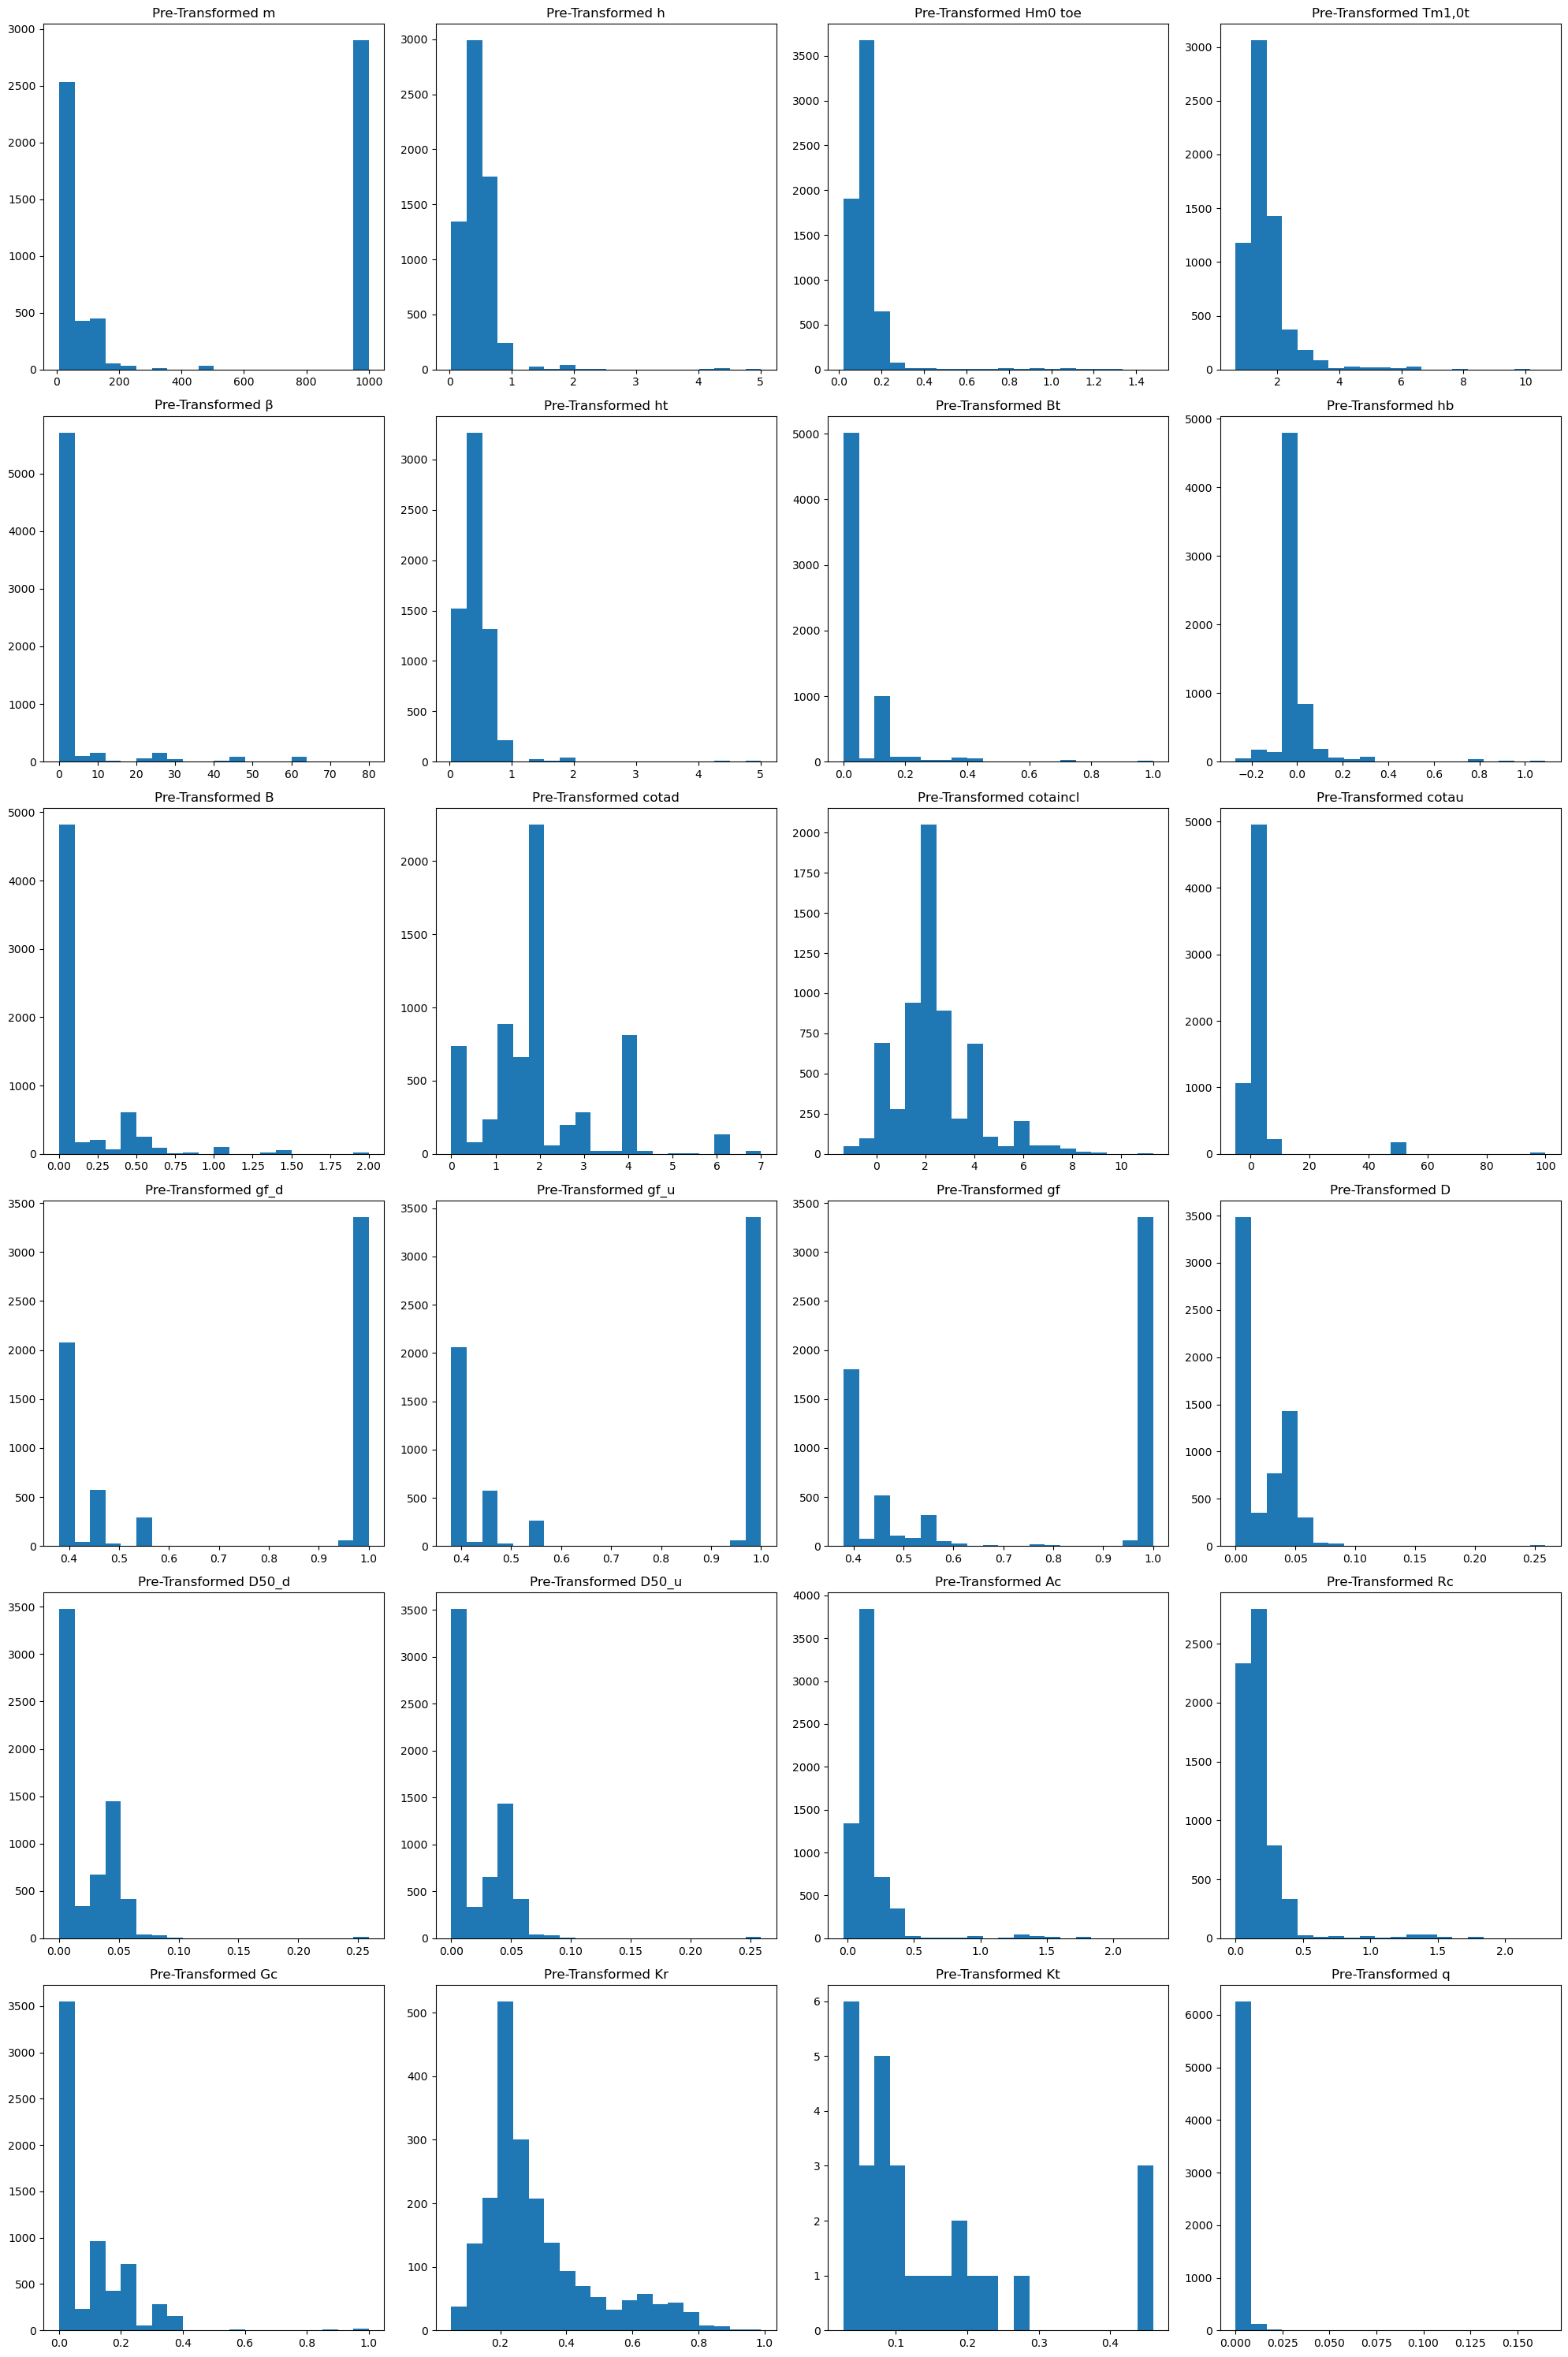

In [32]:
#delete q == 0
dfsave.drop(dfsave.index[dfsave['q'] == 0 ], inplace=True)

k = 0
fig = plt.figure(figsize=(20, 30))
for i in dfsave.columns:
    k = k + 1
    plt.subplot(6, 4, k)
    plt.hist(dfsave[i],bins=20)
    plt.title('Pre-Transformed '+i)
    plt.subplots_adjust(bottom=1,
                    top=2,
                    wspace=.3,
                    hspace=.3)
plt.show()

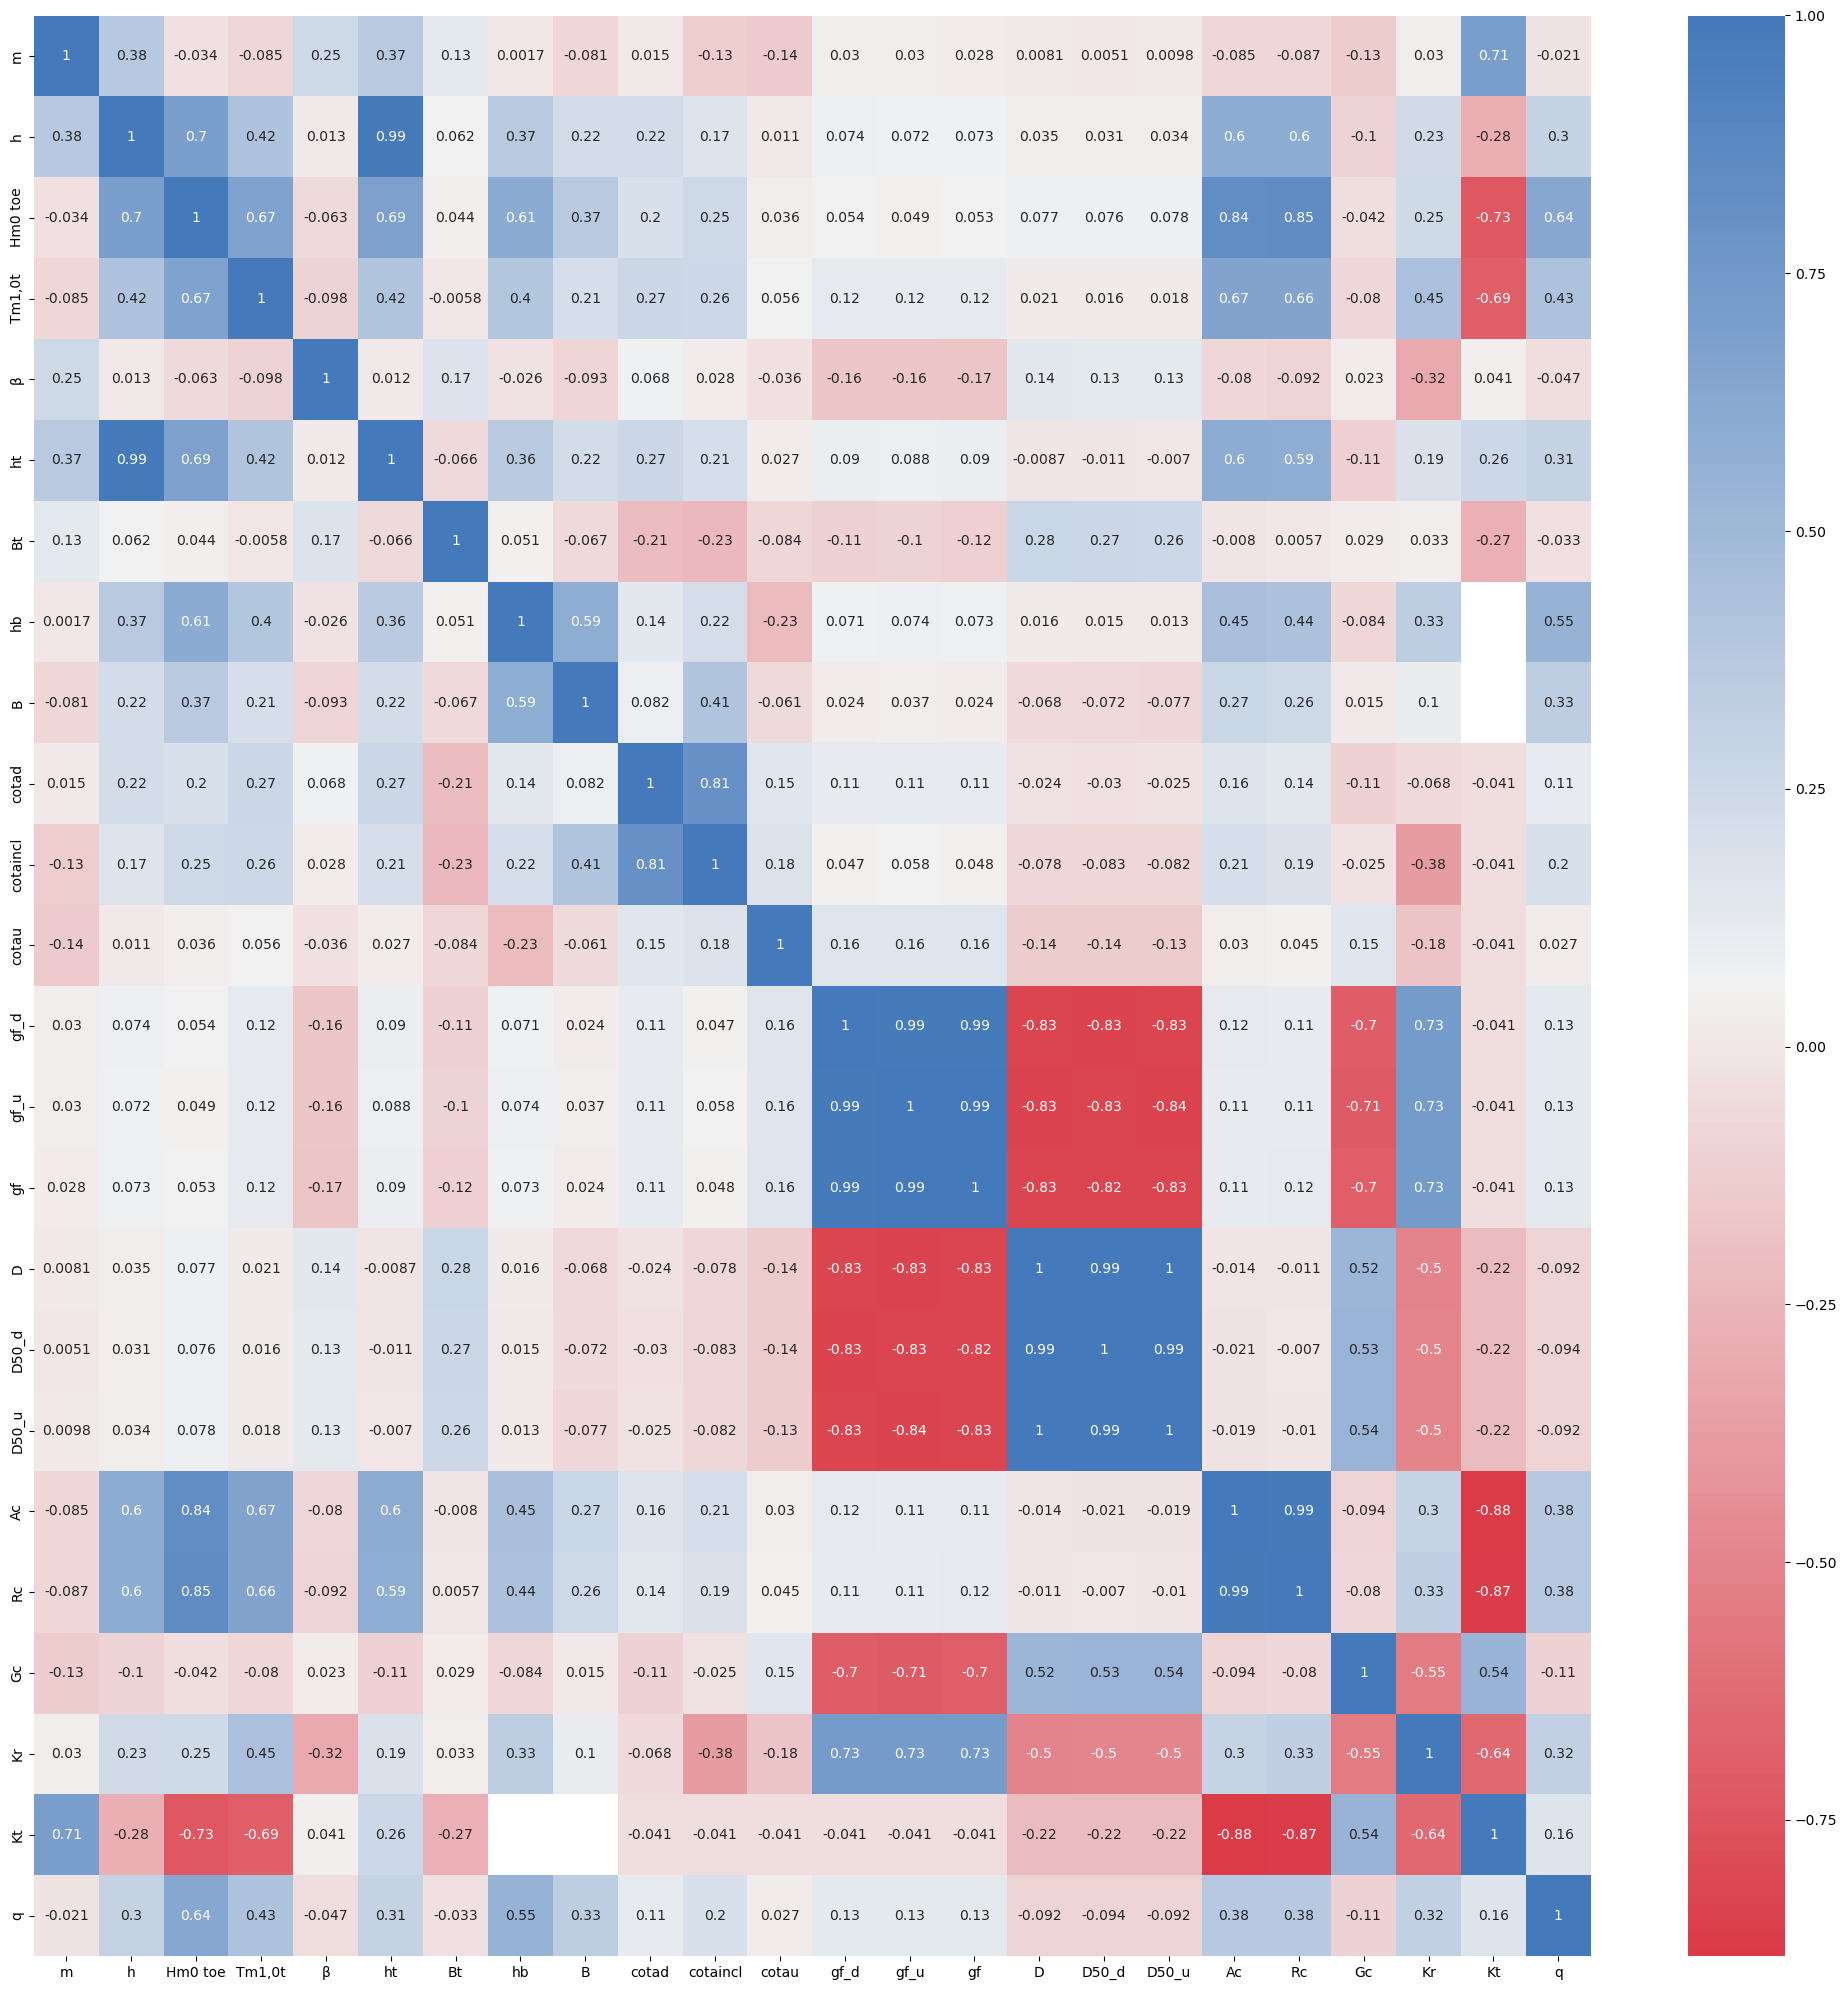

In [33]:
#corr matrix to see correlation of parameters
corr_matrix = dfsave.corr()
f, ax = plt.subplots(figsize=(20,20))
g = sns.heatmap(corr_matrix, cmap = sns.diverging_palette(10, 250, as_cmap = True), annot = True)


In [34]:
#creating an additional feature - compute spectral wave length in deep water lm0 in meter
dfsave['Lm0'] = ((9.81*(dfsave['Tm1,0t'])**2)/(2*np.pi))

# create dataframe containing the RF model parameters
dff = pd.DataFrame({
    'Hm0' :dfsave['Hm0 toe'],
    'Hm0/Lm0':dfsave['Hm0 toe']/dfsave['Lm0'],
    'β':dfsave['β'],
    'h/Lm0':dfsave['h']/dfsave['Lm0'],
    'ht/Hm0':dfsave['ht']/dfsave['Hm0 toe'],
    'Bt/Lm0':dfsave['Bt']/dfsave['Lm0'],
    'hb/Hm0':dfsave['hb']/dfsave['Hm0 toe'],
    'B/Lm0':dfsave['B']/dfsave['Lm0'],
    'Ac/Hm0':dfsave['Ac']/dfsave['Hm0 toe'],
    'Rc/Hm0':dfsave['Rc']/dfsave['Hm0 toe'],
    #'Rc':dfsave['Rc'],
    'Gc/Lm0':dfsave['Gc']/dfsave['Lm0'],
    'm':dfsave['m'],
    'cotad':dfsave['cotad'],
    'cotaincl':dfsave['cotaincl'],
    'gf':dfsave['gf'],
    'q':dfsave['q'],
    'D/Hm0':dfsave['D']/dfsave['Hm0 toe'],
    #target:
    'qAD':np.log10(dfsave['q']/np.sqrt(9.81*(dfsave['Hm0 toe'])**3)),
    })



In [35]:
#save data frame description
b= dff.describe()

#prepare data for the further analysis
discharge_dfsave_output = dfsave.drop(columns =['D', 'gf', 'cotaincl', 'Lm0', 'Kr', 'Kt'])
discharge_dfsave_output.insert(loc=0, column='Label', value=df['Label'])

dfsave_output = dfsave.drop(columns =['D', 'gf', 'cotaincl', 'Lm0','q', 'Kr', 'Kt'])

f_discharge = pd.DataFrame(dfsave['q'])

dfsave_output = dfsave_output.dropna()

#prepare file for ANN tool
dfsave_output['Kr'] = 0
dfsave_output['Kt'] = 0
dfsave_output['q'] = 1


dfsave_output_describe = dfsave_output.describe()
dfsave_output.insert(loc=0, column='Label', value=df['Label'])
#dfsave_output.drop(dfsave.head(1).index, inplace=True)

In [36]:
# Replace infinite updated data with nan
dff.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
dff.dropna(inplace=True)

In [37]:
train_set, test_set = train_test_split(dff, test_size=0.2,random_state=random_state)

scaler = StandardScaler()
# transform data

#scaler_std = StandardScaler()
train_transform = pd.DataFrame(train_set.drop(['Hm0','q','qAD'], axis=1))
desc_train_transform = train_transform.describe()
desc_train_transform.to_excel('desc_train_transform.xlsx') 
train_transform = pd.DataFrame(scaler.fit_transform(train_transform))
train_transform.columns = train_set.drop(['Hm0','q','qAD'], axis=1).columns

test_transform = pd.DataFrame(test_set.drop(['Hm0','q','qAD'], axis=1))

desc_test_transform = test_transform.describe()
desc_test_transform.to_csv('desc_test_transform.csv', decimal=".", sep=' ', header = True, index = False ) 

test_transform = pd.DataFrame(scaler.transform(test_transform))
test_transform.columns = test_set.drop(['Hm0','q','qAD'], axis=1).columns



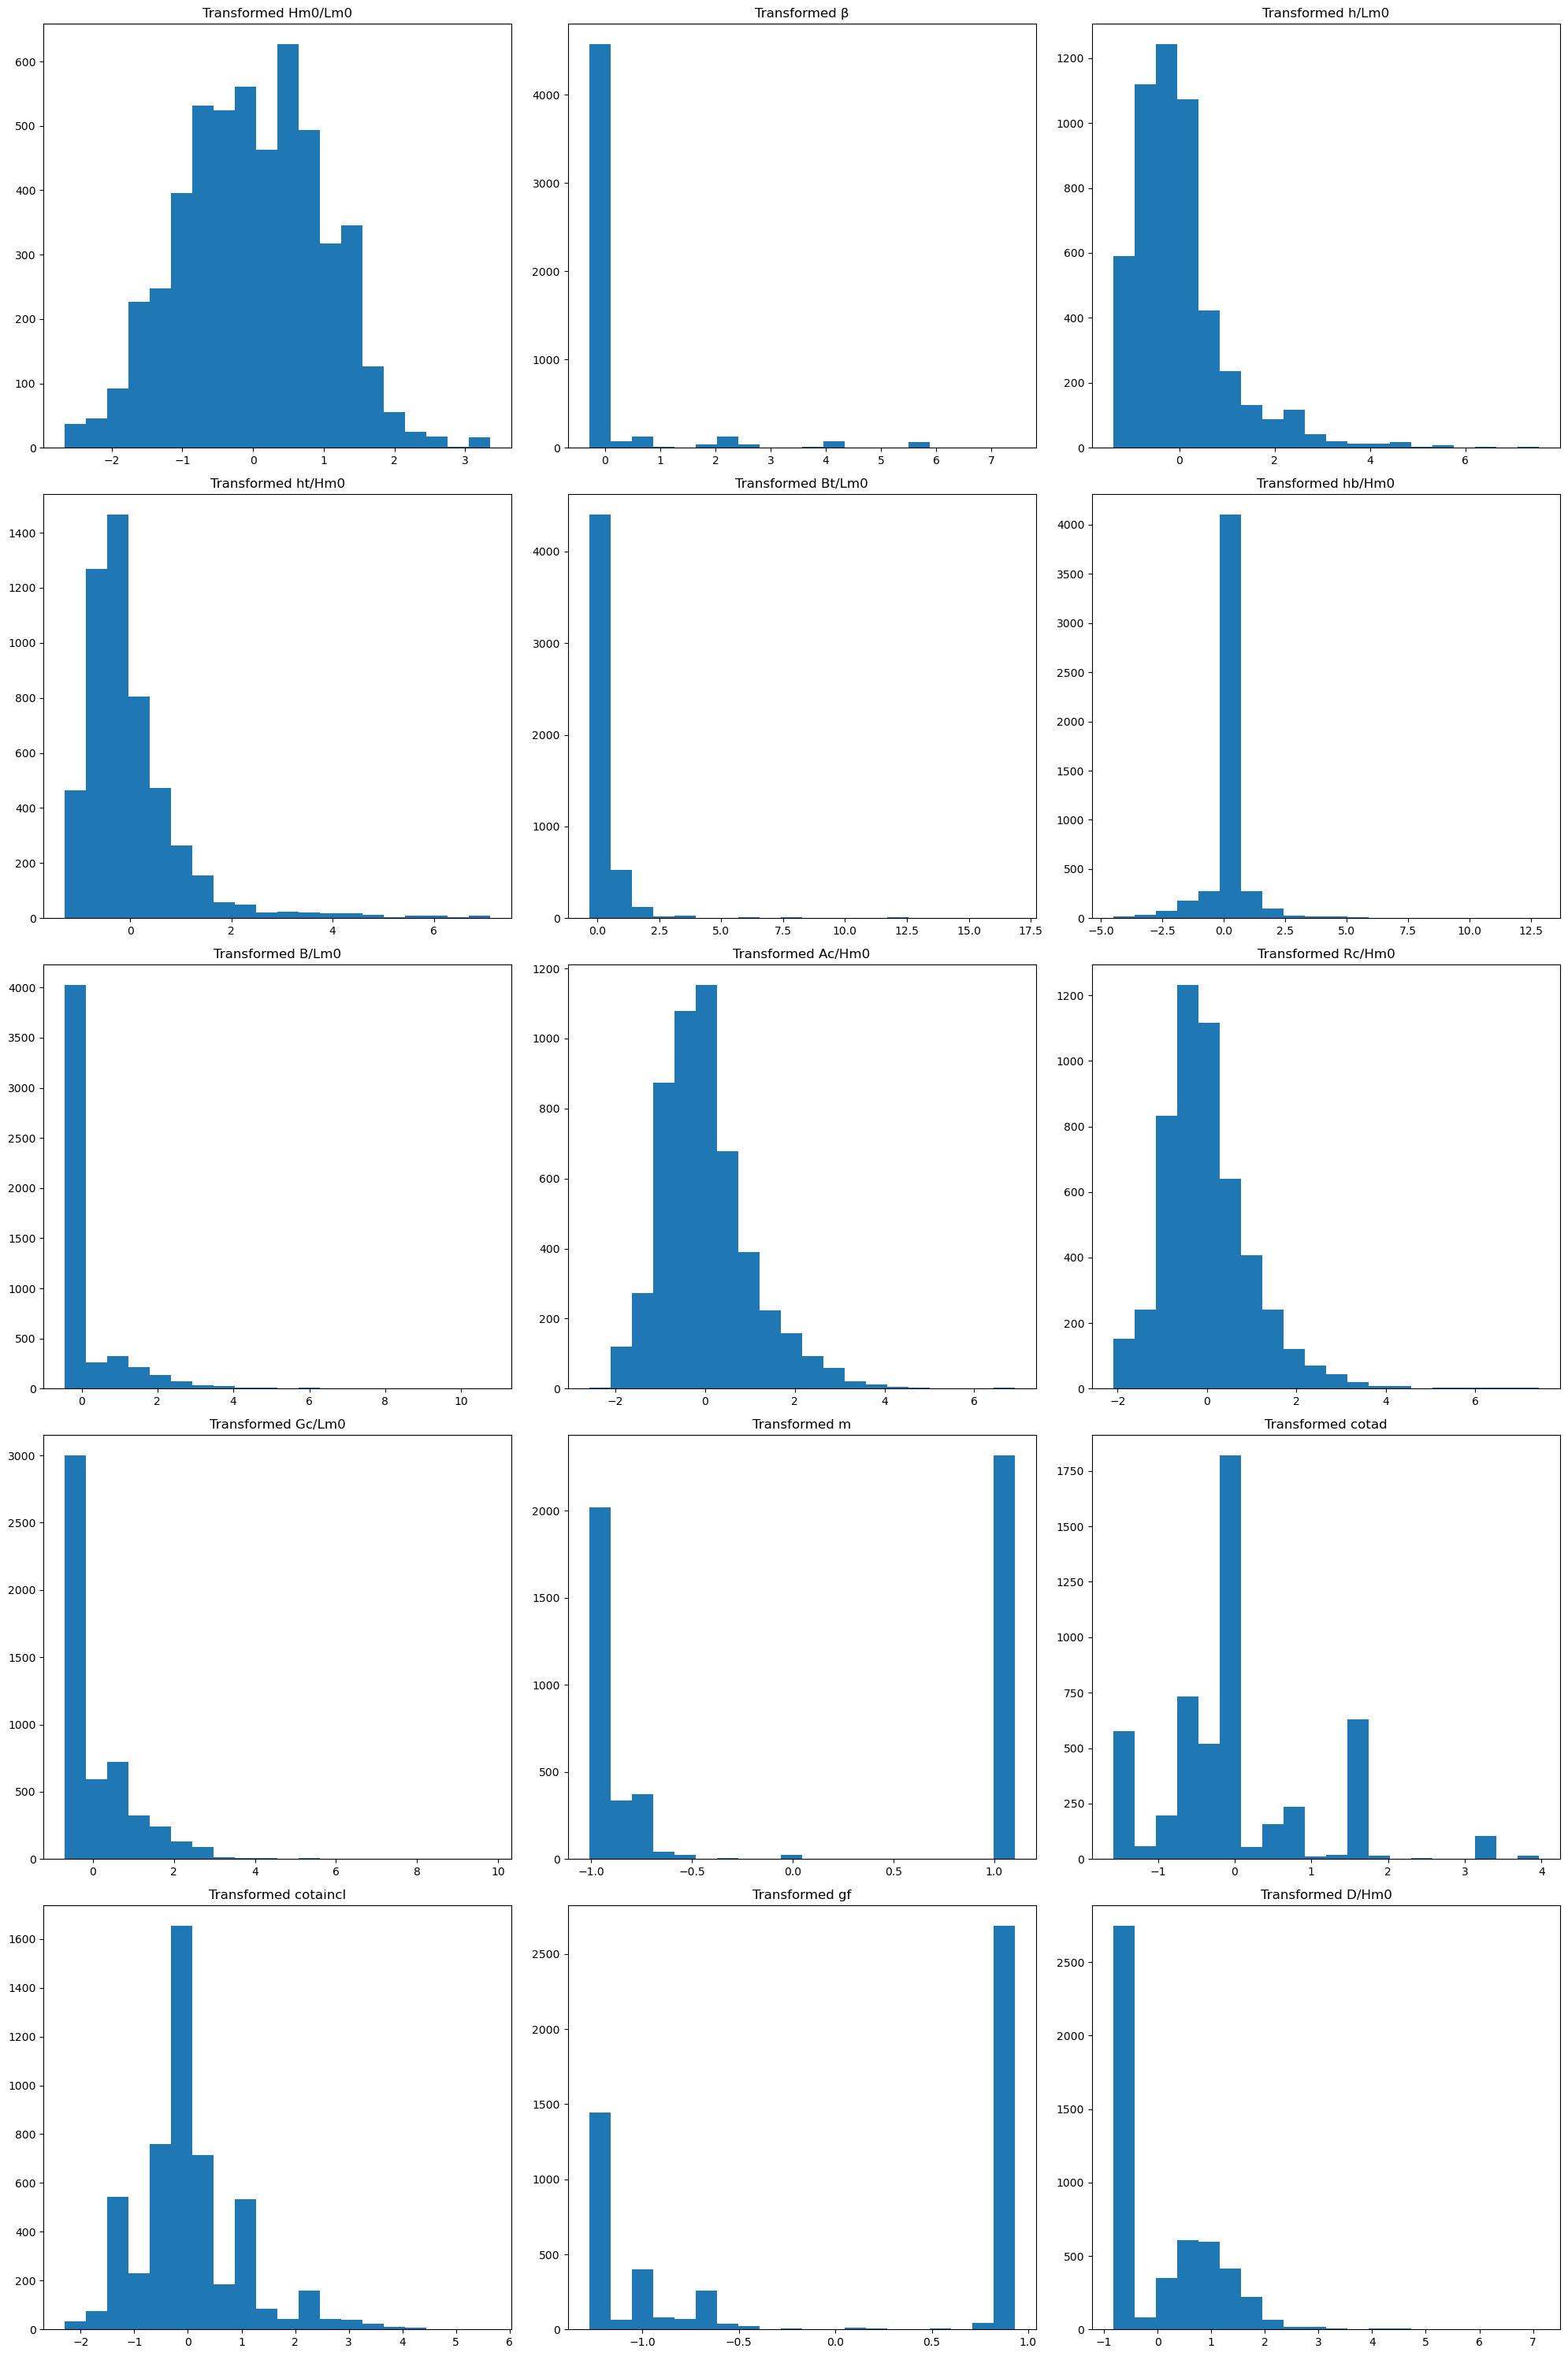

In [38]:
n = 0
fig = plt.figure(figsize=(20, 30))
for i in train_transform.columns:
    n = n + 1
    plt.subplot(5, 3, n)
    plt.hist(train_transform[i],bins=20)
    plt.title('Transformed '+i)
    plt.subplots_adjust(bottom=1,
                    top=2,
                    wspace=.5,
                    hspace=.5)
plt.show()

In [39]:
#organize the data 
train = {
    'features': train_transform,
    'target' : scaler.fit_transform(train_set['qAD'].values.reshape(-1,1))
}
#targetu się nie transformuje
test = {
    'features': test_transform,
    'target' : pd.DataFrame(scaler.fit_transform(test_set['qAD'].values.reshape(-1,1)))
}

# inverse_transform Hm0_test
Hm0_test = pd.DataFrame(test_set['Hm0'])

    # select the metrics
scoring = ['neg_mean_squared_error','r2']

In [40]:
#transform function
def transform(Hm0, data,scaler):
    prediction = scaler.inverse_transform(data.values.reshape(-1,1))
    q_overtopping = (10**(prediction.flatten()))*np.sqrt(9.81*(Hm0_test['Hm0'])**3)
    return q_overtopping

In [41]:
### Add validation data set
# split the train set between train and validation set
train_feature_rf, train_val_feature_rf, train_target_rf, train_val_target_rf = train_test_split(train['features'], train['target'], test_size=0.2,random_state=1123)
train['features_rf'] = train_feature_rf
train['target_rf'] = train_target_rf
train['val_feature_rf'] = train_val_feature_rf
train['val_target_rf'] = train_val_target_rf

#desc_train_feature_rf = pd.DataFrame(train_feature_rf).describe()
#desc_train_target_rf = pd.DataFrame(train_target_rf).describe()
#desc_train_val_feature_rf = train_val_feature_rf.describe()
#desc_train_val_target_rf = pd.DataFrame(train_val_target_rf).describe()

# build function for hyperparameters search

def RandomForestR(params,  scoring, features, target):

    rf = RandomForestRegressor(random_state = 1123)
   
    for x in scoring:
        grid_search = GridSearchCV(estimator = rf, param_grid = params, 
                                   n_jobs = -1, verbose = 2, scoring=x)
       
        grid_search.fit(features, target)
        print()
        print("######### Tuning hyper-parameters for %s" % x)
        print()
        print()
        print("Best parameters set found on development set:")
        if x == 'neg_mean_squared_error':
            print(grid_search.best_params_, ' -----> SCORE RMSE: %f' %
                  np.sqrt(-grid_search.best_score_))
        else:
            print(grid_search.best_params_, ' -----> SCORE: %f' %
                  grid_search.best_score_)
# search hyperparameters

scoring = ['neg_mean_squared_error', 'r2']


In [42]:
# Create the parameter grid based on the results of random search 
params_grid = {
    #'bootstrap': [True],
    'max_depth': [ 25, 37],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [15, 20],
    #'min_samples_split': [6, 32],
    'n_estimators': [141, 199]
}



RandomForestR(params_grid, scoring, train['features'], train['target'].ravel())


Fitting 5 folds for each of 16 candidates, totalling 80 fits

######### Tuning hyper-parameters for neg_mean_squared_error


Best parameters set found on development set:
{'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 199}  -----> SCORE RMSE: 0.384173
Fitting 5 folds for each of 16 candidates, totalling 80 fits

######### Tuning hyper-parameters for r2


Best parameters set found on development set:
{'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 199}  -----> SCORE: 0.852130


In [43]:
### Search the best n_estimator
# search best n_estimators

sum_of_errors=[]
for i in range(1, 501):
    print(i)
    rf = RandomForestRegressor( max_depth=26, n_estimators=i)
    rf.fit(train['features_rf'],train['target_rf'])
    #errors = [mean_squared_error(train['val_target_rf'], prediction)
    #     for prediction in rf.predict(train['val_feature_rf'])]
    errors = []
    for real, pred in zip(train['val_target_rf'], rf.predict(train['val_feature_rf'])):
        try:
            errors.append(mean_squared_error(real, [pred], squared = False))    
        except:
            print(real, [pred])
            #
    sum_of_errors.append(np.mean(errors))

bst_n_estimators = np.argmin(sum_of_errors) + 1



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [44]:
print(bst_n_estimators)

195


Text(0.5, 1.0, 'Mean error vs n_estimators for RF (no Gaussian Noise)')

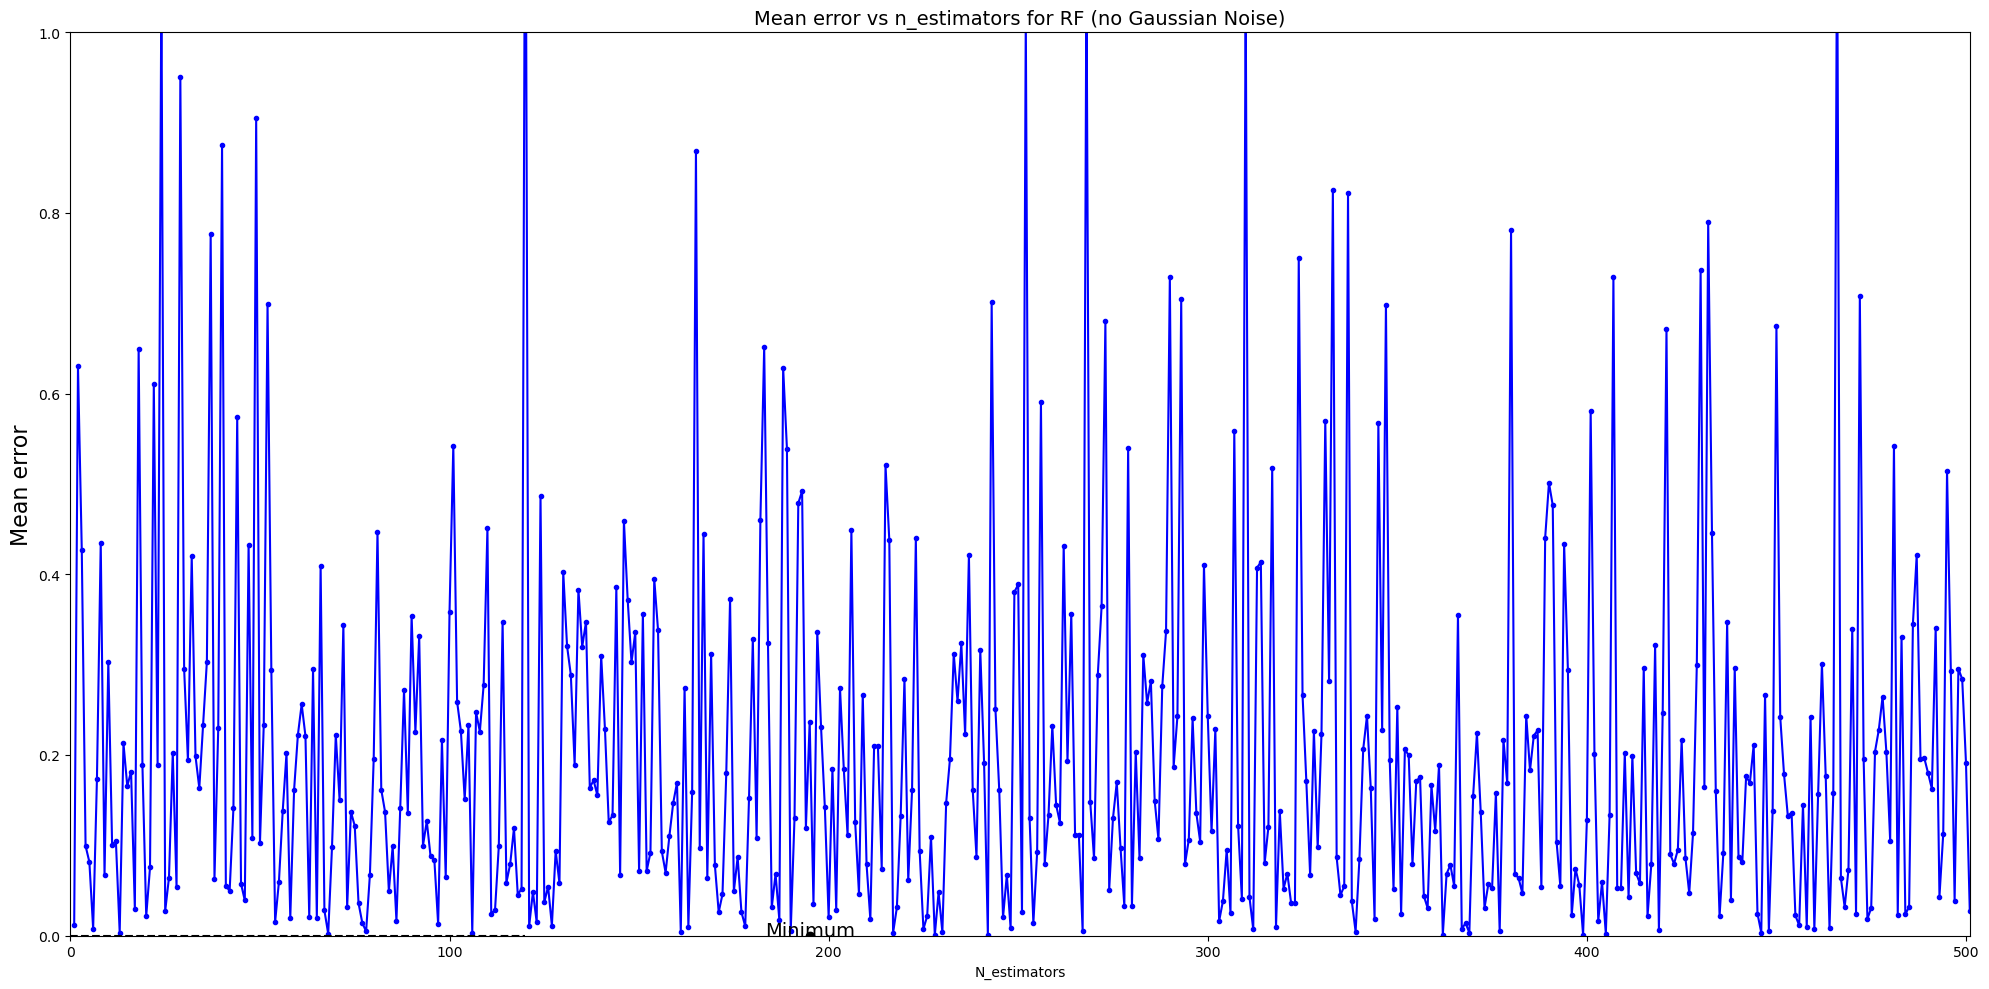

In [49]:
#best
rf_best = RandomForestRegressor(max_depth=25, n_estimators=bst_n_estimators, random_state = random_state)
rf_best.fit(train['features_rf'], train['target_rf'])

#plot validation error for the n_estimators
min_error = np.min(errors)
plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 501, 0, 1])
plt.xlabel("N_estimators")
plt.ylabel("Mean error", fontsize=16)
plt.title("Mean error vs n_estimators for RF (no Gaussian Noise)", fontsize=14)


Text(0.5, 1.0, 'Learning curve showing validation error for RF (no Gaussian Noise)')

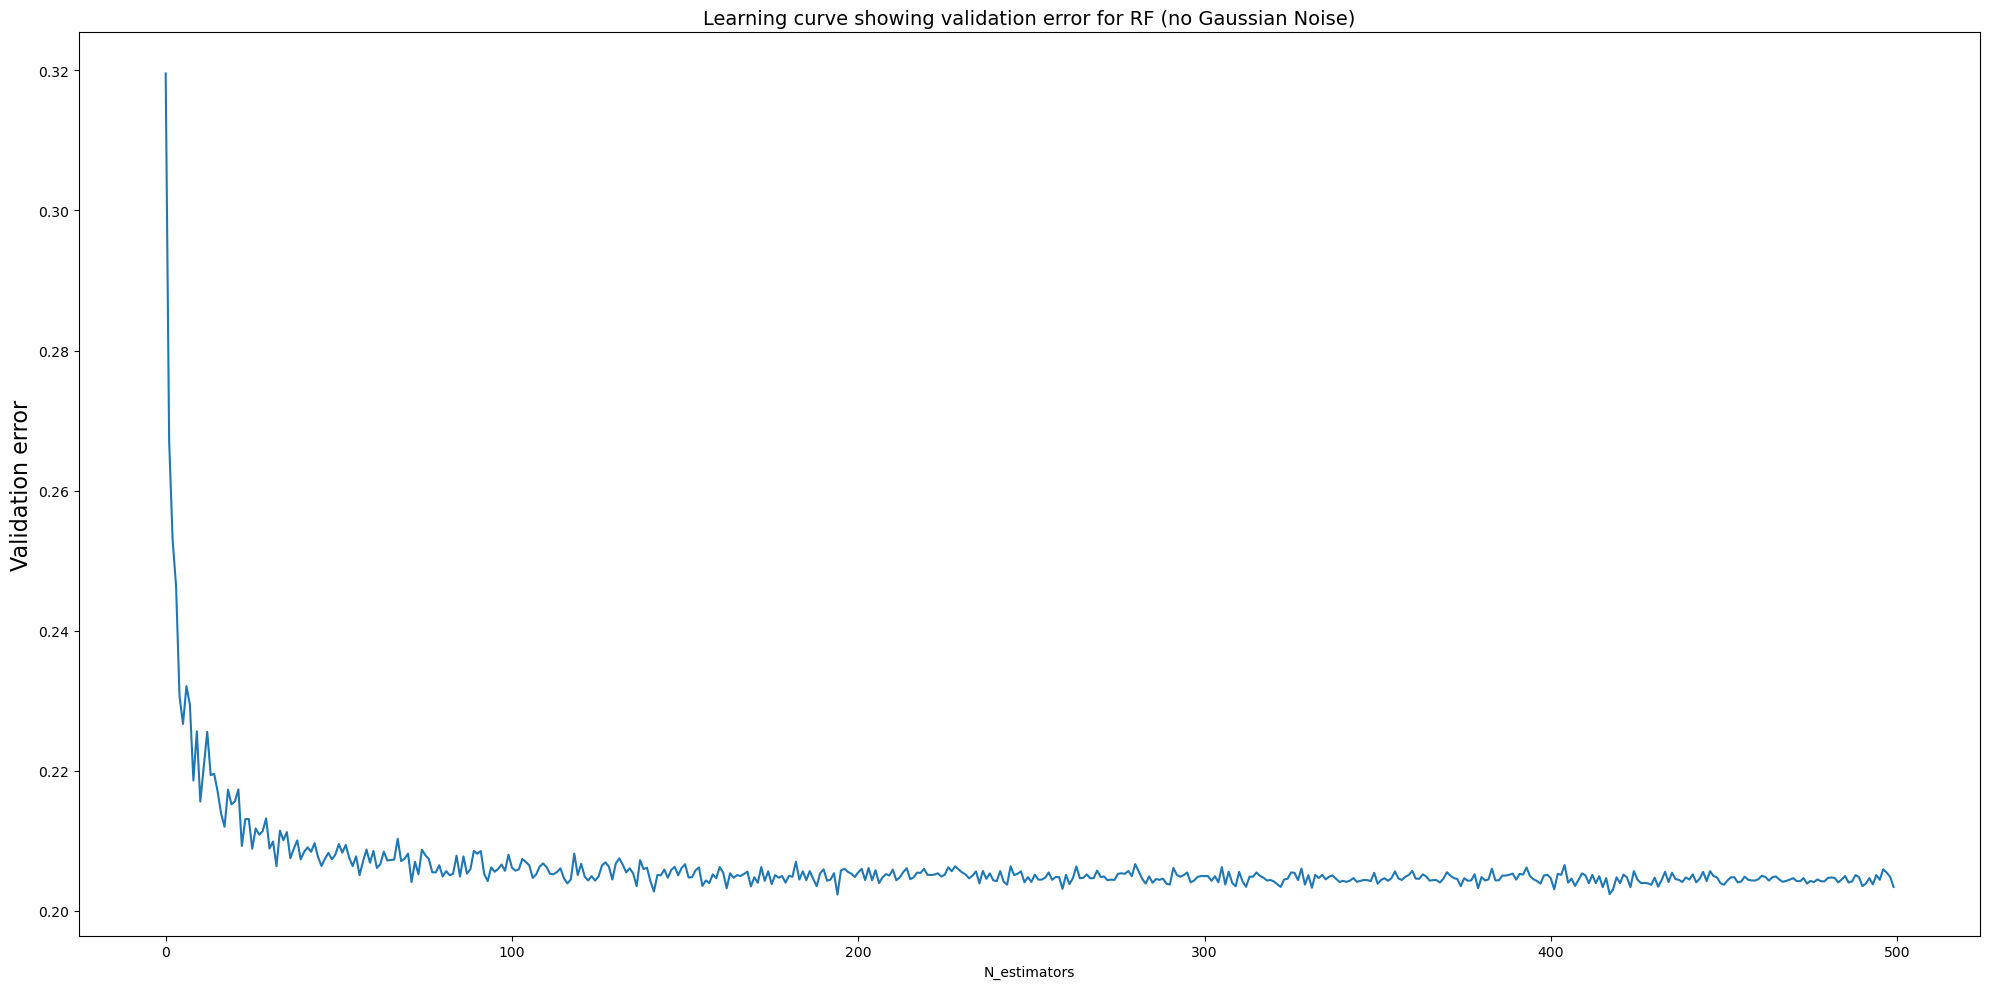

In [50]:
#plot sum of errors
plt.figure(figsize=(20, 10))
plt.plot(sum_of_errors)
plt.ylabel("Validation error", fontsize=16)
plt.xlabel("N_estimators")
plt.title("Learning curve showing validation error for RF (no Gaussian Noise)", fontsize=14)

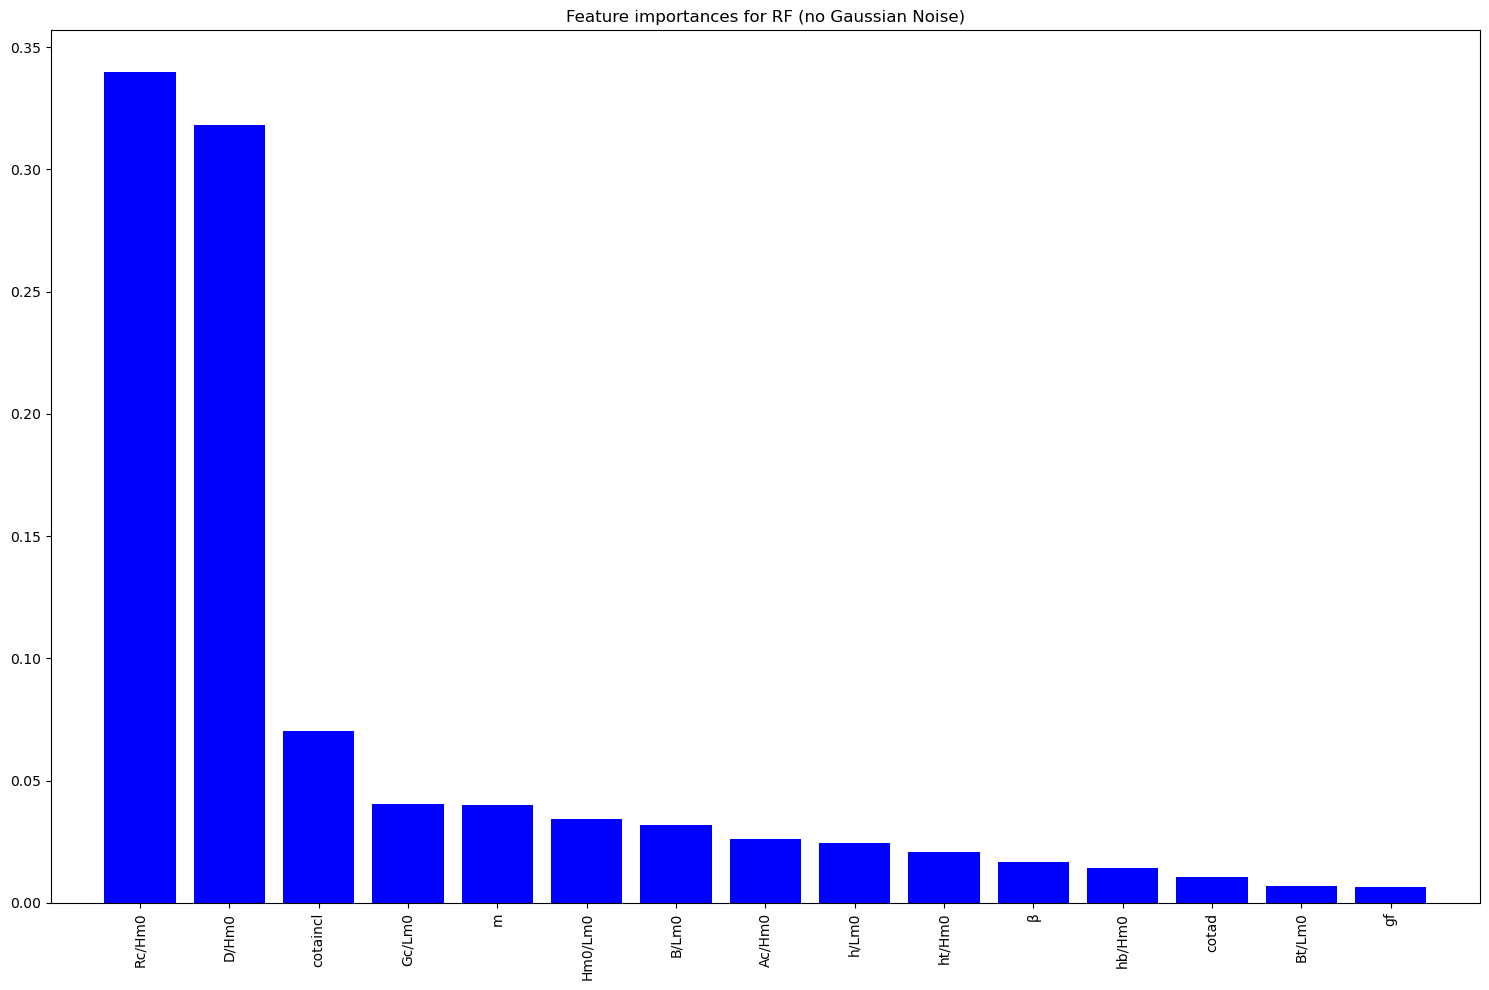

SCORE DATASET TEST for RF (no Gaussian Noise)

R2 TEST
0.9218717391515638

RMSE TEST
0.27951433030962153


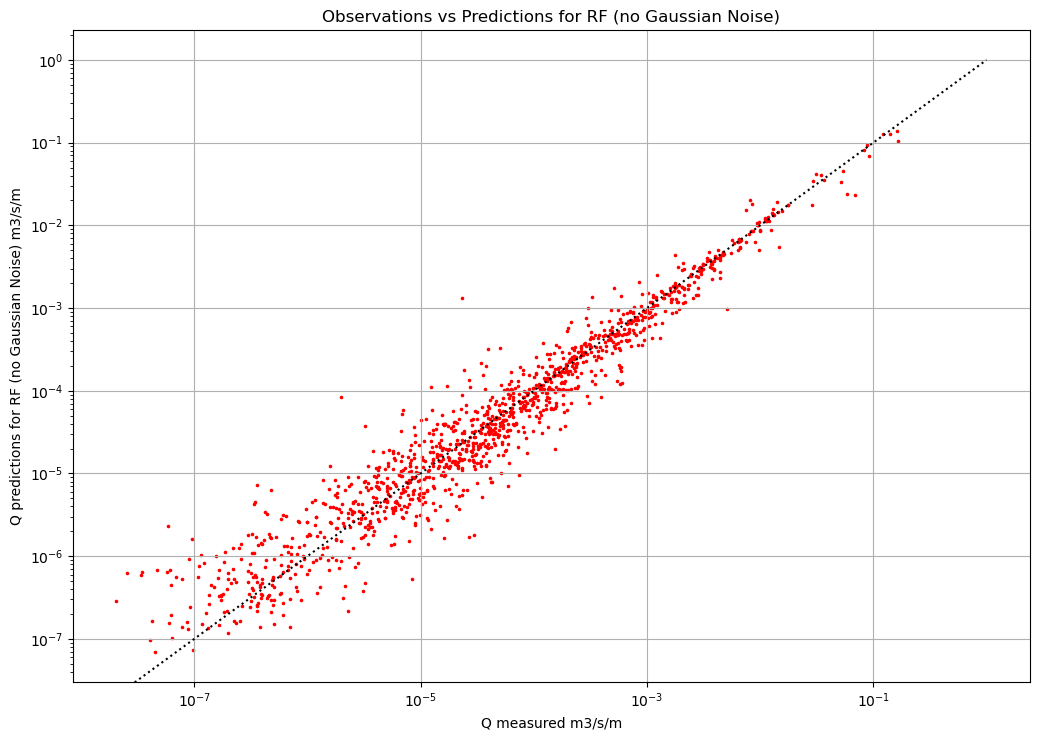

In [51]:
###  Feature importances from t model
# check the feature importance

      
def features_importances(estimator, features):
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances for RF (no Gaussian Noise)")
    plt.bar(range(len(importances)),
            importances[indices], color="blue", align="center")
    plt.xticks(range(len(importances)),
               features.columns[indices], fontsize=10, rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()
    
features_importances(rf,train['features'])
### Build the rf model and make predictions
# run rf with best parameters
# add stochastic rf => reduce Std but increase biais.
rf = RandomForestRegressor(     max_depth=26,
                                n_estimators=bst_n_estimators,
                                random_state=random_state)
rf.fit(train['features'], train['target'].ravel())

prediction = rf.predict(test['features'])
test['predictions'] = pd.DataFrame(prediction)

print("SCORE DATASET TEST for RF (no Gaussian Noise)")
print()
print("R2 TEST")
print(r2_score(test['target'], test['predictions']))
print()
print("RMSE TEST")
print(np.sqrt(mean_squared_error(test['target'], test['predictions']))) 

plt.rcParams["figure.figsize"] = [10.50, 7.50]
plt.rcParams["figure.autolayout"] = True
plt.title('Observations vs Predictions for RF (no Gaussian Noise)')
plt.xlabel("Q measured m3/s/m"), plt.ylabel(
    "Q predictions for RF (no Gaussian Noise) m3/s/m")
plt.scatter(transform(Hm0_test, test['target'],scaler),
            transform(Hm0_test, test['predictions'],scaler),
            s = 10,marker = '.',c='red',
           )
plt.plot(np.linspace(0, 1),
         np.linspace(0, 1), ':k')
#plt.axis([0.00000001, 1, 0.00000001, 1])
plt.loglog()
plt.grid()
